In [3]:
from utils import *
from torchinfo import summary
# from torchsummary import summary
from sklearn.metrics import recall_score

Opening data/2022-12-08-rat_kidney.npy
Converting data to array of 208297 spectra with 573 mass bins.
After removing empty spectra, 161547 sectra remain.
No scaling of the data!


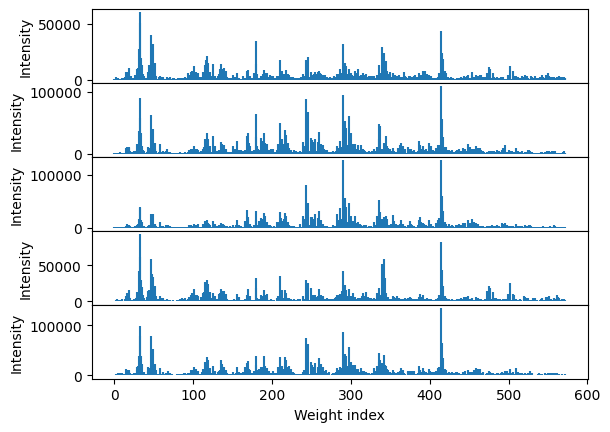

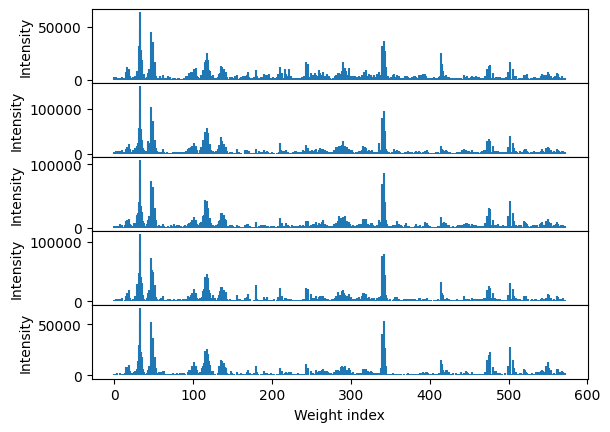

<module 'matplotlib.pyplot' from 'c:\\Users\\wvand\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
class opt():
    pass
opt.limitmajor = 500000
opt.testsplit = 0.2
# opt.datafile="data/exp1_minmaxf.npz"
opt.datafile="data/exp1_Standard.npz"
opt.specsize = 573
opt.limitclasses=[0,2,6,7,8]
opt.scalemethod = "None"

create_labeled_dataf(opt) #comment out if not needed, takes 'long' time

X_train,y_train,X_test,y_test = load_labeled_data(opt.datafile)
plot_spect(X_train[y_train==0],[0,1,2,3,4],title=False)
plot_spect(X_train[y_train==3],[0,1,2,3,4],title=False)


In [ ]:
opt.latent_dim = 100
opt.numclasses=1
opt.device='cpu'
opt.specsize=573
class1 = 3
class2 = 4

num_samples=1000
X1_train = X_train[y_train == class1][0:num_samples]
X2_train = X_train[y_train == class2][0:num_samples]
X1_test = X_test[y_test == class1][0:num_samples]
X2_test = X_test[y_test == class2][0:num_samples]

secondclassnoise = False
if secondclassnoise == False:
    pass
else:
# Untrained generator
    generator = cDC_Generator_fc(opt).to(opt.device)
    generator.apply(weights_init_normal)
    y=torch.tensor(np.zeros(sum(y_train==class2))).long()
    z = torch.FloatTensor(np.random.normal(0,1, (sum(y_train==class2),opt.latent_dim))).to(opt.device)
    print(z.size())
    print(y.size())
    X2_train = generator.forward(z,y).detach().numpy()

    y=torch.tensor(np.zeros(sum(y_test==class2))).long()
    z = torch.FloatTensor(np.random.normal(0,1, (sum(y_test==class2),opt.latent_dim))).to(opt.device)
    X2_test = generator.forward(z,y).detach().numpy()

Xtrain = np.vstack((X1_train,X2_train))
Xtest = np.vstack((X1_test,X2_test))
ytrain = np.hstack((np.zeros(num_samples),np.ones(num_samples)))
ytest = np.hstack((np.zeros(num_samples),np.ones(num_samples)))
# ytrain = np.hstack((np.zeros(sum(y_train==class1)),np.ones(sum(y_train==class2))))
# ytest = np.hstack((np.zeros(sum(y_test==class1)),np.ones(sum(y_test==class2))))

# plt.figure()
# plt.plot(Xtrain[ytrain==0][0])
# plt.plot(Xtrain[ytrain==1][0])
# plt.legend(['data','noise'])
# print(ytest)

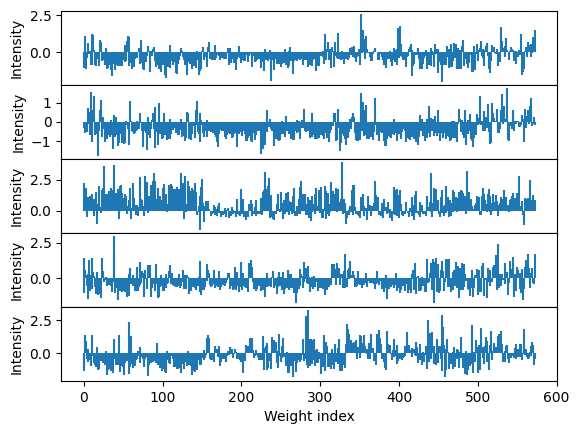

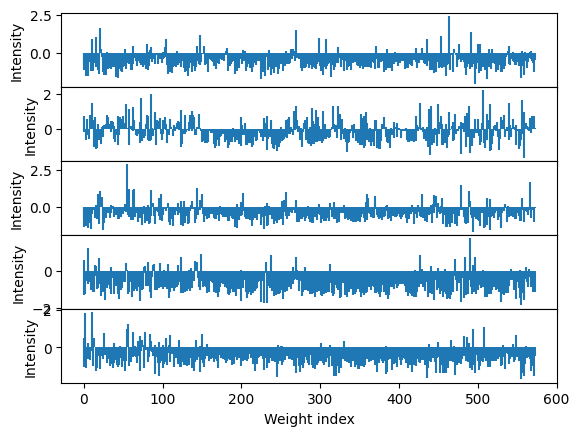

<module 'matplotlib.pyplot' from 'c:\\Users\\wvand\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
plot_spect(X2_train,[0,1,2,3,4],title=False)
plot_spect(X1_train,[0,1,2,3,4],title=False)


In [ ]:
opt.optimizer = "SGD"
opt.GANslr = 0.005 # standard 0.0002
opt.b1 = 0.5
opt.b2 = 0.999
opt.savegans = 'Experiments/exp2024/Disciminator_as_classifier/'
opt.GANsbsize = 64
opt.specsize = np.shape(X_train)[1]
opt.numclasses=1
opt.GANs_n_epochs=100  #00
opt.removeproggan=True
# opt.loss = torch.nn.MSELoss()
opt.loss = torch.nn.BCELoss()
# train_gans(opt,X_GAN_training,y_GAN_training,X_test[y_test==0],y_test[y_test==0])

# model = cDC_Discriminator(opt).to(opt.device)
model = cGANdiscriminator_3(opt).to(opt.device)
# model = cDC_Discriminator_aux(opt).to(opt.device)
# model = simplestdisc(opt).to(opt.device)
model.apply(weights_init_normal)
crit = opt.loss.to(opt.device)
optim= torch.optim.SGD(model.parameters(),lr=opt.GANslr)
# optim = torch.optim.Adam(model.parameters(),lr=opt.GANslr)
# print(model)
# summary(cDC_Discriminator(opt),input_data=(torch.randn(opt.GANsbsize,1,573),torch.randn(1,opt.GANsbsize)))
# summary(cDC_Discriminator(opt),input_data=(torch.randn(1,1,573),torch.randint(1,(1,))),device=opt.device)

In [ ]:
class CustomDataset():
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)  # Assuming integer labels for classification

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y
data = CustomDataset(Xtrain,ytrain)
trainloader = torch.utils.data.DataLoader(data,batch_size=opt.GANsbsize,shuffle=True)
data = CustomDataset(Xtest,ytest)
testloader = torch.utils.data.DataLoader(data,batch_size=opt.GANsbsize,shuffle=True)


In [ ]:
loss_on_test = []
acc_on_test = []
loss_on_train = []
acc_on_train = []

testloss = []
trainloss = []
testacc = []
trainacc = []
trainrec = []
testrec = []

for epoch in tqdm(range(opt.GANs_n_epochs)):
    # testloss = []
    # trainloss = []
    # testacc = []
    # trainacc = []
    for input, labels in trainloader:
        optim.zero_grad()
        labels = labels.to(opt.device)
        #update noise every step
        y = labels[labels==1]
        z = torch.FloatTensor(np.random.normal(0,1, (sum(labels==1),opt.latent_dim))).to(opt.device)

        # input[labels==1]=generator.forward(z,y)
        outputs = model(input.to(opt.device),torch.zeros_like(labels).to(opt.device))
        loss = crit(outputs,labels.unsqueeze(-1).float().to(opt.device))
        loss.backward()
        optim.step()

        trainloss.append(loss.item())
        model.eval()
        outputs = model(input.to(opt.device),torch.zeros_like(labels).to(opt.device))
        trainacc.append((outputs.squeeze().round()==labels).float().mean().cpu())
        trainrec.append(recall_score(labels.detach().numpy(),outputs.squeeze().detach().numpy().round()))
        model.train()
    # loss_on_train.append(np.mean(trainloss))
    # acc_on_train.append(np.mean(trainacc))
    for input, labels in testloader:
        model.eval()
        outputs = model(input.to(opt.device),torch.zeros_like(labels).to(opt.device))
        loss = crit(outputs,labels.unsqueeze(-1).float().to(opt.device))
        testloss.append(loss.item())
        testacc.append((outputs.squeeze().round()==labels.to(opt.device)).float().mean().cpu())
        testrec.append(recall_score(labels.detach().numpy(),outputs.squeeze().detach().numpy().round()))
    # acc_on_test.append(np.mean(testacc))
    # loss_on_test.append(np.mean(testloss))
    model.train()
    # tqdm.set_postfix({'Test accuracy',acc_on_test[-1]})
    # print(loss.item()) 

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


0.65625 0.765625 0.953125
[tensor(0.4844), tensor(0.5312), tensor(0.4688), tensor(0.4688), tensor(0.6250), tensor(0.6562), tensor(0.7031), tensor(0.6562), tensor(0.6875), tensor(0.8281), tensor(0.7656), tensor(0.8281), tensor(0.8594), tensor(0.7969), tensor(0.7969), tensor(0.8594), tensor(0.7188), tensor(0.8281), tensor(0.7969), tensor(0.8750), tensor(0.8750), tensor(0.8750), tensor(0.8750), tensor(0.8281), tensor(0.9219), tensor(0.8750), tensor(0.8750), tensor(0.8750), tensor(0.8750), tensor(0.9219), tensor(0.8438), tensor(0.9375), tensor(0.8438), tensor(0.8750), tensor(0.8438), tensor(0.8594), tensor(0.8125), tensor(0.8906), tensor(0.9062), tensor(0.9062), tensor(0.8906), tensor(0.9062), tensor(0.9531), tensor(0.8438), tensor(0.9531), tensor(0.9219), tensor(0.9062), tensor(0.9062), tensor(0.9531), tensor(0.8750), tensor(0.9531), tensor(0.9688), tensor(0.9062), tensor(0.9531), tensor(0.8906), tensor(0.8594), tensor(0.9688), tensor(0.8906), tensor(0.9375), tensor(0.9219), tensor(0.9375

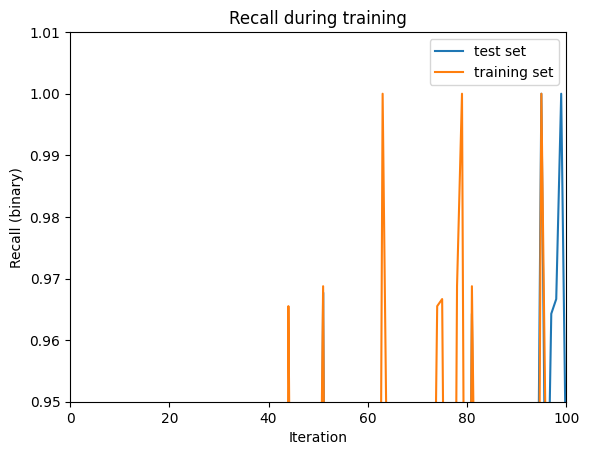

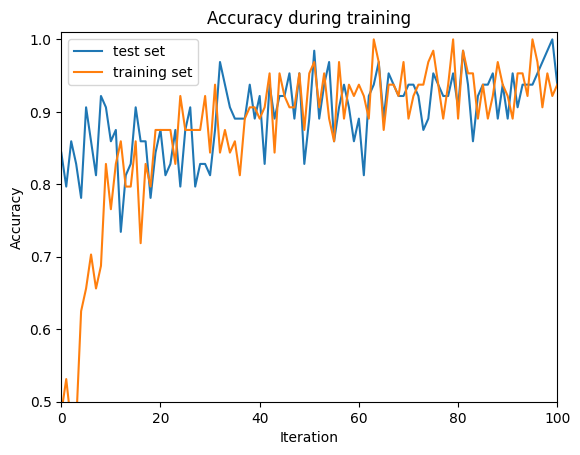

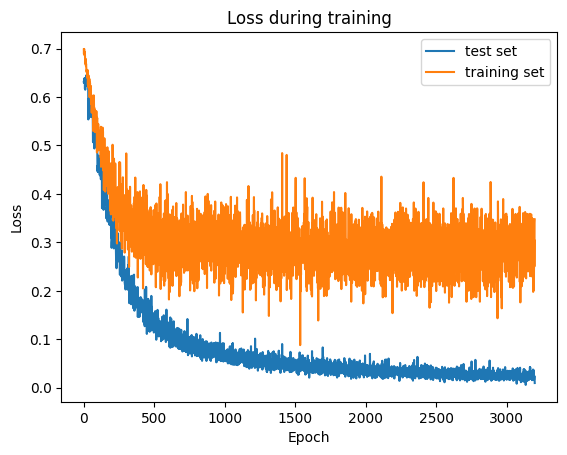

In [ ]:
plt.figure()
plt.plot(testrec)
plt.plot(trainrec)
plt.xlabel('Iteration')
plt.ylabel('Recall (binary)')
plt.xlim([0,100])
plt.ylim([0.95,1.01])
plt.title('Recall during training')
plt.legend(['test set','training set'])

plt.figure()
plt.plot(testacc)
plt.plot(trainacc)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xlim([0,100])
plt.ylim([0.5,1.01])
plt.title('Accuracy during training')
plt.legend(['test set','training set'])

plt.figure()
plt.plot(testloss)
plt.plot(trainloss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.yscale('log')
plt.title('Loss during training')
plt.legend(['test set','training set'])

print(trainacc[5].item(),trainacc[10].item(),trainacc[50].item())
print(trainacc)

In [ ]:
print(type(torch.tensor(Xtest).to(opt.device).long()))
print(np.shape(Xtest))
y_test=np.hstack((np.zeros(num_samples),np.ones(num_samples)))
model.eval()
y_pred=model(torch.tensor(Xtest).to(opt.device).long(),torch.zeros_like(torch.from_numpy(ytest)).to(opt.device).long()).detach().cpu().numpy().round()
print(classification_report(ytest,y_pred))

<class 'torch.Tensor'>
(2000, 573)
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1000
         1.0       0.98      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [ ]:
model.eval()
y_pred=model(torch.tensor(Xtrain).to(opt.device).long(),torch.zeros_like(torch.from_numpy(ytrain)).to(opt.device).long()).detach().cpu().numpy().round()
print(classification_report(ytrain,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1000
         1.0       0.97      1.00      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



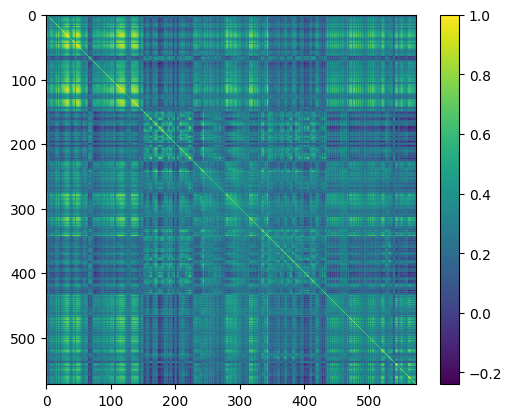

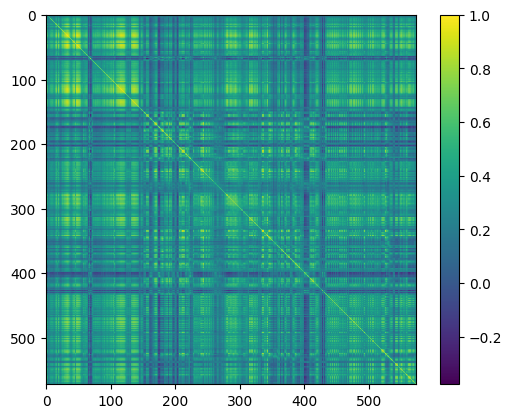

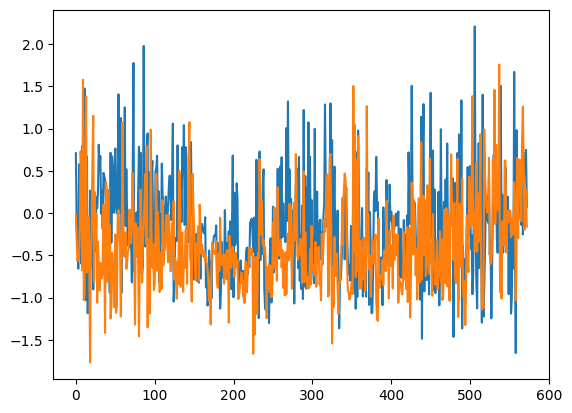

In [ ]:
# print(np.shape(np.cov(Xtrain[ytrain==0],rowvar=False)))
# plt.imshow(np.cov(X_train[y_train==0],rowvar=False))
plt.figure()
plt.imshow(np.corrcoef(Xtrain[ytrain==0],rowvar=False))
plt.colorbar()

plt.figure()
plt.imshow(np.corrcoef(Xtrain[ytrain==1],rowvar=False))
plt.colorbar()

plt.figure()
plt.plot(Xtrain[ytrain==0][1])
plt.plot(Xtrain[ytrain==1][1])